# Lição de casa Aula 12 - PSI5790

Nome: Jean Carlos Mello Xavier Faria

Nusp: 11259628

In [1]:
#Descarregar segm_eliret.zip
url='http://www.lps.usp.br/hae/apostila/segm_eliret.zip'
import os; nomeArq=os.path.split(url)[1]
if not os.path.exists(nomeArq):
  print("Baixando o arquivo",nomeArq,"para diretorio default",os.getcwd())
  os.system("wget -nc -U 'Firefox/50.0' "+url)
else:
  print("O arquivo",nomeArq,"ja existe no diretorio default",os.getcwd())
print("Descompactando arquivos novos de",nomeArq)
os.system("unzip -u "+nomeArq)

Baixando o arquivo segm_eliret.zip para diretorio default /content
Descompactando arquivos novos de segm_eliret.zip


0

# Parte A

Lendo:  treino.csv
Lendo:  valida.csv
Lendo:  teste.csv
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 16, 16, 40)           1040      ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 16, 16, 40)           0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 8, 8, 12)             12012     ['dropout[0][0]']             
                                      

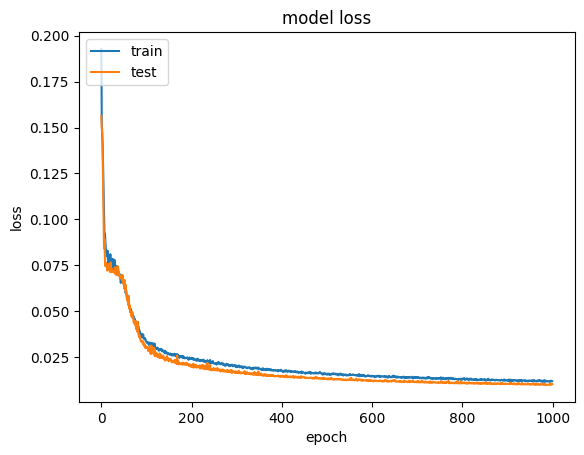

Training loss: 0.005639072507619858
Validation loss: 0.010115818120539188
Test loss: 0.011012396775186062


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
#fcn-train1.py
#Treina rede fcn para segmentacao semantica de eliret
import os; os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Conv2D, Conv2DTranspose, concatenate
from tensorflow.keras import optimizers
import sys; import cv2; import numpy as np; import matplotlib.pyplot as plt

def impHistoria(history):
  print(history.history.keys())
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss'); plt.ylabel('loss'); plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

def leCsv(nomeDir,nomeArq):
  print("Lendo: ",nomeArq); arq=open(os.path.join(nomeDir,nomeArq),"r")
  lines=arq.readlines(); arq.close(); n=len(lines)

  nl,nc = 32,32;
  AX=np.empty((n,nl,nc),dtype='uint8'); AY=np.empty((n,nl,nc),dtype='uint8')
  i=0;
  for linha in lines:
    linha=linha.strip('\n'); linha=linha.split(';')
    AX[i]=cv2.imread(os.path.join(nomeDir,linha[0]),0)
    AY[i]=cv2.imread(os.path.join(nomeDir,linha[1]),0)
    i=i+1

  ax= np.float32(AX)/255.0; ay= np.float32(AY)/255.0 #Entre 0 e +1
  ax = ax.reshape(n, nl, nc, 1); ay = ay.reshape(n, nl, nc, 1)
  return ax, ay

#<<<<<<<<<<<<< main <<<<<<<<<<<<<<<<<
bdDir = "."
ax, ay = leCsv(bdDir,"treino.csv")
vx, vy = leCsv(bdDir,"valida.csv")
qx, qy = leCsv(bdDir,"teste.csv")
outDir = "."; os.chdir(outDir)

nl,nc = 32,32; input_shape = (nl,nc,1); batch_size = 20; epochs = 1000


inputs = Input(shape=input_shape)
# Encoder
conv1 = Conv2D(40, kernel_size=(5,5), strides=2, activation='relu', padding='same')(inputs) #16x16
drop1 = Dropout(0.25)(conv1)

conv2 = Conv2D(12, kernel_size=(5,5), strides=2, activation='relu', padding='same')(drop1) #8x8
drop2 = Dropout(0.25)(conv2)

conv3 = Conv2D(12, kernel_size=(5,5), strides=2, activation='relu', padding='same')(drop2) #4x4
drop3 = Dropout(0.25)(conv3)

conv4 = Conv2D(12, kernel_size=(5,5), strides=1, activation='relu', padding='same')(drop3) #4x4
drop4 = Dropout(0.25)(conv4)

# Decoder
up4 = Conv2DTranspose(12, kernel_size=(5,5), strides=2, activation='relu', padding='same')(drop4) #8x8
up4 = concatenate([up4,drop2 ])
drop4 = Dropout(0.25)(up4)

up5 = Conv2DTranspose(40, kernel_size=(5,5), strides=2, activation='relu', padding='same')(drop4) #16x16
up5 = concatenate([up5, drop1])
drop5 = Dropout(0.25)(up5)

outputs = Conv2DTranspose(1, kernel_size=(5,5), strides=2, padding='same')(drop5) #32x32

model = Model(inputs=[inputs], outputs=[outputs])

model.compile(optimizer=optimizers.Adam(), loss='mean_squared_error')

model.summary()


opt=optimizers.Adam()
model.compile(optimizer=opt, loss='mean_squared_error')
history=model.fit(ax, ay, batch_size=batch_size, epochs=epochs, verbose=0, validation_data=(vx,vy))
impHistoria(history)

score = model.evaluate(ax, ay, verbose=0); print('Training loss:', score)
score = model.evaluate(vx, vy, verbose=0); print('Validation loss:', score)
score = model.evaluate(qx, qy, verbose=0); print('Test loss:', score)
model.save('fcn-train1_2.h5')

1/1 [==============================] - 0s 125ms/step


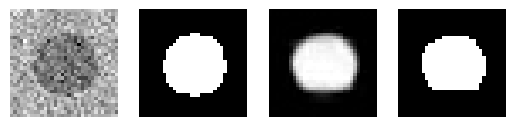

In [ ]:
#fcn-pred1.py
#Faz segmentacao semantica usando rede gerada pelo fcn-train1.py
import os; os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import cv2; import numpy as np
import tensorflow.keras as keras
from tensorflow.keras.models import load_model

#<<<<<<<<<<<<<<<<<<< main <<<<<<<<<<<<<<<<<<<<<<
bdDir = "."
outDir = "."; os.chdir(outDir)
nome="077"
inImgX = nome+"x.png"; inImgY = nome+"y.png"
outImgG =nome+"g.png"; outImgB =nome+"b.png"
arquivoRede = "fcn-train1_2.h5"

model = load_model(os.path.join(outDir,arquivoRede))
QX=cv2.imread(os.path.join(bdDir,inImgX),0)
QY=cv2.imread(os.path.join(bdDir,inImgY),0)
nl=QX.shape[0]; nc=QX.shape[1]
qx=np.float32(QX)/255.0 #Entre 0 e +1
qx=qx.reshape(1, nl, nc, 1)

qp=model.predict(qx); qp=qp.reshape(nl,nc) # entre 0 e +1

QPG=255.0*qp; QPG=np.clip(QPG,0,255) # Entre 0 e 255
QPG=np.uint8(QPG); cv2.imwrite(os.path.join(outDir,outImgG),QPG)

QPB=np.zeros((nl,nc),dtype='uint8'); QPB[ qp>=0.5 ] = 255
cv2.imwrite(os.path.join(outDir,outImgB),QPB)

from matplotlib import pyplot as plt
f = plt.figure()
f.add_subplot(1,4,1); plt.imshow(QX,cmap="gray"); plt.axis('off')
f.add_subplot(1,4,2); plt.imshow(QY,cmap="gray"); plt.axis('off')
f.add_subplot(1,4,3); plt.imshow(QPG,cmap="gray"); plt.axis('off')
f.add_subplot(1,4,4); plt.imshow(QPB,cmap="gray"); plt.axis('off')
plt.show(block=True)

# Parte B

Lendo:  treino.csv
Lendo:  valida.csv
Lendo:  teste.csv
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 32, 32, 1)]          0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 32, 32, 40)           400       ['input_2[0][0]']             
                                                                                                  
 conv2d_5 (Conv2D)           (None, 16, 16, 40)           14440     ['conv2d_4[0][0]']            
                                                                                                  
 dropout_6 (Dropout)         (None, 16, 16, 40)           0         ['conv2d_5[0][0]']            
                                    

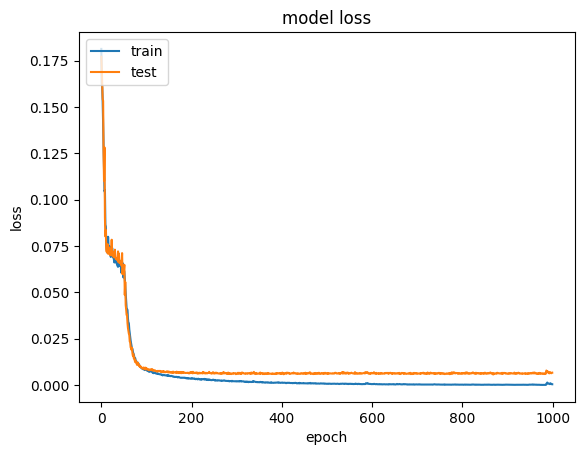

Training loss: 8.13346923678182e-05
Validation loss: 0.0067079211585223675
Test loss: 0.005917046219110489


In [ ]:
#<<<<<<<<<<<<< main <<<<<<<<<<<<<<<<<
bdDir = "."
ax, ay = leCsv(bdDir,"treino.csv")
vx, vy = leCsv(bdDir,"valida.csv")
qx, qy = leCsv(bdDir,"teste.csv")
outDir = "."; os.chdir(outDir)

nl,nc = 32,32; input_shape = (nl,nc,1); batch_size = 20; epochs = 1000


inputs = Input(shape=input_shape)
# Encoder
conv1 = Conv2D(40, kernel_size=(3,3), strides=1, activation='relu', padding='same')(inputs) #32x32
conv1_stride = Conv2D(40, kernel_size=(3,3), strides=2, activation='relu', padding='same')(conv1)  #16x16
drop1 = Dropout(0.25)(conv1_stride)

conv2 = Conv2D(12, kernel_size=(3,3), strides=1, activation='relu', padding='same')(drop1) #16x16
conv2_stride = Conv2D(12, kernel_size=(3,3), strides=2, activation='relu', padding='same')(conv2) #8x8
drop2 = Dropout(0.25)(conv2_stride)

conv3 = Conv2D(12, kernel_size=(3,3), strides=1, activation='relu', padding='same')(drop2) #8x8
conv3_stride = Conv2D(12, kernel_size=(3,3), strides=2, activation='relu', padding='same')(conv3) #4x4
drop3 = Dropout(0.25)(conv3_stride)

conv4 = Conv2D(12, kernel_size=(3,3), strides=1, activation='relu', padding='same')(drop3) #4x4
conv4 = Conv2D(12, kernel_size=(3,3), strides=1, activation='relu', padding='same')(conv4) #4x4
drop4 = Dropout(0.25)(conv4)

# Decoder
up4 = Conv2DTranspose(12, kernel_size=(3,3), strides=1, activation='relu', padding='same')(drop4) #4x4
up4 = Conv2DTranspose(12, kernel_size=(3,3), strides=2, activation='relu', padding='same')(up4)   #8x8
up4 = concatenate([up4,conv3])
drop4 = Dropout(0.25)(up4)
conv4 = Conv2D(12, kernel_size=(3,3), strides=1, activation='relu', padding='same')(drop4) #8x8
conv4 = Conv2D(12, kernel_size=(3,3), strides=1, activation='relu', padding='same')(conv4) #8x8

up5 = Conv2DTranspose(40, kernel_size=(3,3), strides=1, activation='relu', padding='same')(conv4) #8x8
up5 = Conv2DTranspose(40, kernel_size=(3,3), strides=2, activation='relu', padding='same')(up5)   #16x16
up5 = concatenate([up5, conv2])
drop5 = Dropout(0.25)(up5)
conv5 = Conv2D(40, kernel_size=(3,3), strides=1, activation='relu', padding='same')(drop5) #16x16
conv5 = Conv2D(40, kernel_size=(3,3), strides=1, activation='relu', padding='same')(conv5) #16x16

up6 = Conv2DTranspose(40, kernel_size=(3,3), strides=1, activation='relu', padding='same')(conv5) #16x16
up6 = Conv2DTranspose(40, kernel_size=(3,3), strides=2, activation='relu', padding='same')(up6)   #32x32
up6 = concatenate([up6, conv1])
drop5 = Dropout(0.25)(up6)
conv6 = Conv2D(40, kernel_size=(3,3), strides=1, activation='relu', padding='same')(drop5) #32x32
conv6 = Conv2D(40, kernel_size=(3,3), strides=1, activation='relu', padding='same')(conv6) #32x32

outputs = Conv2D(1, kernel_size=(1,1), strides=1, padding='same')(conv6) #32x32

model = Model(inputs=[inputs], outputs=[outputs])

model.compile(optimizer=optimizers.Adam(), loss='mean_squared_error')

model.summary()


opt=optimizers.Adam()
model.compile(optimizer=opt, loss='mean_squared_error')
history=model.fit(ax, ay, batch_size=batch_size, epochs=epochs, verbose=0, validation_data=(vx,vy))
impHistoria(history)

score = model.evaluate(ax, ay, verbose=0); print('Training loss:', score)
score = model.evaluate(vx, vy, verbose=0); print('Validation loss:', score)
score = model.evaluate(qx, qy, verbose=0); print('Test loss:', score)
model.save('fcn-train1.h5')


1/1 [==============================] - 1s 859ms/step


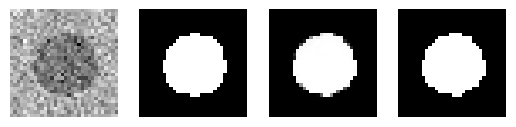

In [ ]:
#<<<<<<<<<<<<<<<<<<< main <<<<<<<<<<<<<<<<<<<<<<
bdDir = "."
outDir = "."; os.chdir(outDir)
nome="077"
inImgX = nome+"x.png"; inImgY = nome+"y.png"
outImgG =nome+"g.png"; outImgB =nome+"b.png"
arquivoRede = "fcn-train1.h5"

model = load_model(os.path.join(outDir,arquivoRede))
QX=cv2.imread(os.path.join(bdDir,inImgX),0)
QY=cv2.imread(os.path.join(bdDir,inImgY),0)
nl=QX.shape[0]; nc=QX.shape[1]
qx=np.float32(QX)/255.0 #Entre 0 e +1
qx=qx.reshape(1, nl, nc, 1)

qp=model.predict(qx); qp=qp.reshape(nl,nc) # entre 0 e +1

QPG=255.0*qp; QPG=np.clip(QPG,0,255) # Entre 0 e 255
QPG=np.uint8(QPG); cv2.imwrite(os.path.join(outDir,outImgG),QPG)

QPB=np.zeros((nl,nc),dtype='uint8'); QPB[ qp>=0.5 ] = 255
cv2.imwrite(os.path.join(outDir,outImgB),QPB)

from matplotlib import pyplot as plt
f = plt.figure()
f.add_subplot(1,4,1); plt.imshow(QX,cmap="gray"); plt.axis('off')
f.add_subplot(1,4,2); plt.imshow(QY,cmap="gray"); plt.axis('off')
f.add_subplot(1,4,3); plt.imshow(QPG,cmap="gray"); plt.axis('off')
f.add_subplot(1,4,4); plt.imshow(QPB,cmap="gray"); plt.axis('off')
plt.show(block=True)